<a href="https://colab.research.google.com/github/so-dipe/Data-Science-and-Machine-Learning-Projects/blob/main/Crypto_TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sudalairajkumar/cryptocurrencypricehistory

In [ ]:
! unzip cryptocurrencypricehistory

# Predicting the Daily Closing Price of Cryptocurrencies using ARMA model.

In [ ]:
import time
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
import seaborn as sns

warnings.filterwarnings('ignore')

In [ ]:
def loadCoin(coinpath):
  coin_df = pd.read_csv(coinpath)
  coin_df.drop(columns=['Symbol', 'Name', 'SNo', 'Volume', 'Marketcap', 'High', 'Low', 'Open'], inplace=True)
  coin_df = coin_df.set_index('Date')
  coin_df = coin_df['Close']
  return coin_df

btc = loadCoin('/content/coin_Bitcoin.csv')
btc.head()



Date
2013-04-29 23:59:59    144.539993
2013-04-30 23:59:59    139.000000
2013-05-01 23:59:59    116.989998
2013-05-02 23:59:59    105.209999
2013-05-03 23:59:59     97.750000
Name: Close, dtype: float64

The function loadCoin, loads the csv file containing information about the coin price action. So, since we want to create a time series model, we only need one column (y, in this case the closing price of the coin) and need to sent time as the index. We therefore drop all the other columns we dont need like 'Symbol', 'Name', ...

We then check for missing values in the dataset...

In [ ]:
def null(coin_df):
  print(coin_df.isnull().sum())

null(btc)


0


There are no missing values in the dataset, so...

We now plot the time series

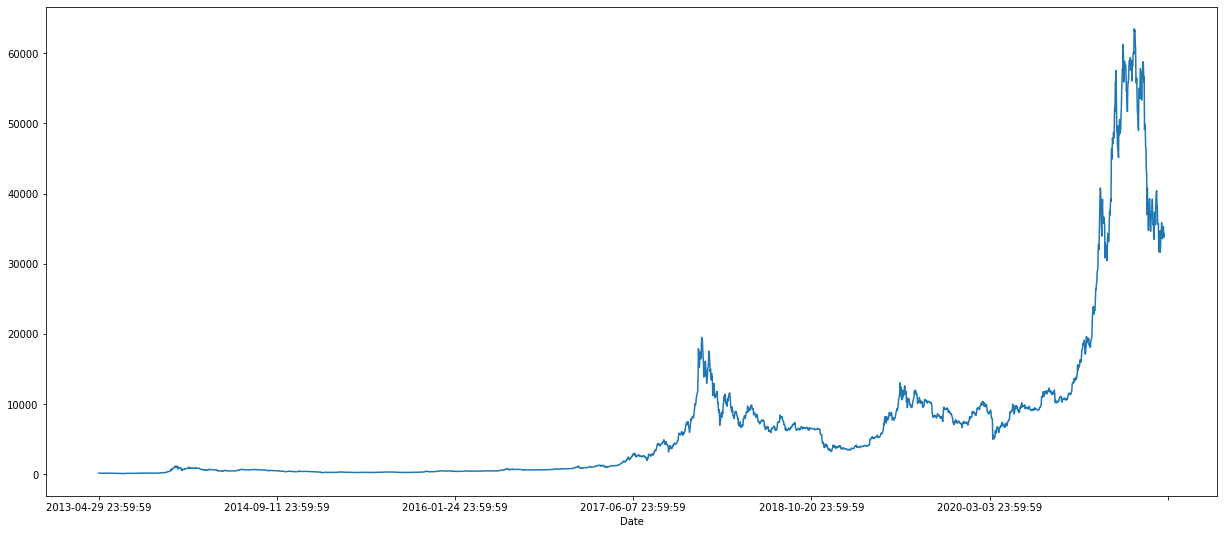

In [ ]:
def plotTS(coin_df):
  fig, ax = plt.subplots(figsize=(21, 9))
  coin_df.plot(ax=ax);

plotTS(btc)

Next, we plot the AutoCorrelation and Partial Correlation of the series. To determin the best value for p (lag for AR) and q (for MA)

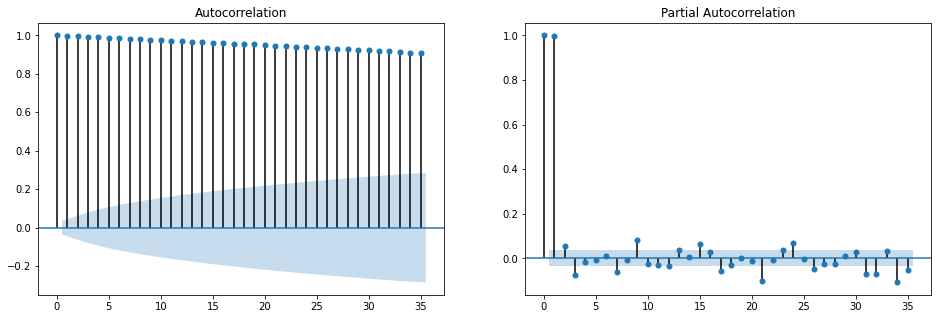

In [ ]:
def plotCoinCorr(coin_df):
  fig, ax = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
  plot_acf(coin_df, ax=ax[0])
  plot_pacf(coin_df, ax=ax[1])

plotCoinCorr(btc)

Has can be seen, the daily closing price of BTC has a high correlation with the previous 1-30 days, I also check for with a lag of 100 and the correlation was still in the statistical significance zone. (I didn't show the plot here, you're just going to take my word for it)

## Train Test Split

In [ ]:
def train_test_split(coin_df, test_size=0.9):
  cutoff = int(len(coin_df) * 0.9)
  y_train = coin_df[:cutoff]
  y_test = coin_df[cutoff:]
  return [y_train, y_test]

btc_train, btc_test = train_test_split(btc)

The function train_test_split splits the dataset into the training and test set, this function is different from the one used to split for other ml models since it has no random state, this is because the data is a timeseries data and we need the past to predict the future.

## Baseline Model

We use calculate the mean and use MAE for the as the baseline of the model, i.e we assume that future values of the series is just the mean value of the past. This gives us a guideline as to show if our model is better than the bare minimum.

In [ ]:
def baseline(coin_train):
  coin_mean = round(coin_train.mean())
  coin_pred_mean = [coin_mean] * len(coin_train)
  baseline_mae = mean_absolute_error(coin_pred_mean, coin_train)
  print(f'The mean of the training set is {round(coin_mean, 2)}')
  print(f'The Baseline MAE is {round(baseline_mae, 2)}')

baseline(btc_train)

The mean of the training set is 3636
The Baseline MAE is 3534.36


### Select Hyperparameters by Iteration

We now create the ARMA model by selecting hyperparameters, we do this by creating a range of p and q values and iterate to find the best on. This is a computational expensive step and it is advisable to select a relatively small range.

In [ ]:
def ARMA(coin_train, p_params, q_params):
  mae_grid = dict()
  for p in p_params:
    mae_grid[p] = list()
    for q in q_params:
      order = (p, 0, q)
      start_time = time.time()
      model = ARIMA(coin_train, order=order).fit();
      elasped_time = round(time.time() - start_time, 2)
      print(f'Time taken to train model of order {order} was {elasped_time} seconds')
      coin_pred = model.predict()
      mae = mean_absolute_error(coin_train, coin_pred)
      mae_grid[p].append(mae)
      
  return mae_grid

p_params = range(0, 24, 8)
q_params = range(3)
mae_grid = ARMA(btc_train, p_params, q_params)

Time taken to train model of order (0, 0, 0) was 0.01 seconds
Time taken to train model of order (0, 0, 1) was 0.88 seconds


ValueError: ignored

The model gets expensize computationally speaking as we increase the value of p (number of lags). Infact, the time elasped increases exponentially as p increases. So when picking a hyperparameter we have to consider both it's cost (computational) and accuracy. 

In [ ]:
mae_df = pd.DataFrame(mae_grid)
mae_df.head()

,0,8,16
0,3534.312225,109.649443,110.355532
1,1819.744293,109.638231,110.623746


Putting MAE_grid (accuracy of the model across different values of p and q) into a DataFrame to make visualization using seaborn heatmap easy

Text(0.5, 1.0, 'ARMA grid search')

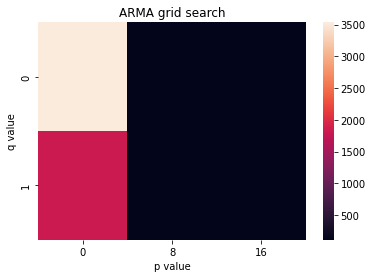

In [ ]:
sns.heatmap(mae_df)
plt.xlabel('p value')
plt.ylabel('q value')
plt.title('ARMA grid search')

Normally in a Time Series model, we decompose the series to remove seasonality and trend and also test for the model stationarity (constant mean and variance accross time) using the AD fuller test, by rejecting the null-hypothesis.
But as I'm not yet an expert, I don't see the need for this and most times, we don't end up using any information we get from if the model is stationary or not.